In [1]:
import os
import matplotlib.pyplot as plt
import datetime
import json
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress

from helpers.expr_data import ExprData
from helpers.scale_data import ScaleData
from helpers.similarity import Similarity
from helpers.feature_selection import FeatureSelection

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
import random
np.random.seed(47907)
random.seed(15213)

In [4]:
'''
Generate scatter plot by similarity
Attributes:
    simi_mtxs : list of simi_mtxs or simi_col_mtxs using different number of features
    simi_data : should be same for all simi_mtxs
    feature_groups: labels of the feature group: top3, top7, plan, res, all
    root_idx: the i-th experiment as the base run, will plot pairwise distance between the base run and other runs
    method_type: Type of method used to calculate similarity
    colwise: True if the calculation is columnwised, False if not
'''
def plot_scores_diff_feature_num(simi_mtxs, simi_data, feature_groups, root_idx, method_type, colwise=False, note=''):
    fig, ax = plt.subplots(figsize=(4*len(feature_groups)/3, 4))
    zipped = []
    for simi_mtx, feature_group in zip(simi_mtxs, feature_groups):       
        curr_zipped = list(zip(simi_data.wl_groups, simi_data.wl_names, [feature_group]*simi_data.get_num_exprs(), simi_mtx[root_idx]))
        del curr_zipped[root_idx]
        zipped += curr_zipped
    X_p = pd.DataFrame(zipped, columns=['run', 'workload','feature_group', 'distance'])
    X_p = X_p.astype({'distance': float})
    res3 = X_p[X_p['feature_group'] == 'res_3']
    res3 = res3.sort_values('distance', inplace=False)
    print(res3.head(8))

    print(X_p[X_p['feature_group'] == 'res_3'].shape)
    # X_p.drop([root_idx],inplace=True)

    
    sns.barplot(y="distance", x="feature_group", hue="workload", data=X_p, ax=ax, 
                    palette=sns.color_palette()[:X_p['workload'].nunique()])
    plt.xlabel('')
    plt.ylabel('Normalized Distance')
    
    expr_idx = simi_data.wl_groups[root_idx]
    wl_name = simi_data.wl_names[root_idx] 
    cpu_num_val = simi_data.cpu_nums[root_idx]
    if colwise:
        colwise_label = 'Independent'
    else:
        colwise_label = 'Dependent'
    title = 'Base Workload: {}, Method: {} {}.{}'.format(
        wl_name, cpu_num_val, colwise_label, method_type, note)
    fname = '{}{}_cpu{}_{}_{}{}.pdf'.format(wl_name, expr_idx, cpu_num_val, colwise_label, method_type, note)
    if len(feature_groups) == 3:
        plt.legend(bbox_to_anchor=(-0.3, 1, 1.35, 0), loc='lower left', ncol=2, mode="expand")
    else:    
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=3, mode="expand")
    print(title)
    plt.savefig(f'figs/TPCC_{fname}', bbox_inches = 'tight')
    plt.show()

In [5]:
data = ExprData()
data.load_pickle()
data = data.remove_by_wlname(['ycsb', 'xml'])
data = data.fix_tpch()
data_by_sku = data.split_by_sku()

# use for later distinguish btw plan and system metrics
perf_features = data.perf_feature_cols
plan_features = data.plan_feature_cols
all_features = data.feature_cols

feature_group_all = ['plan_3', 'plan_7', 'plan', 'res_3', 'res_5', 'res', 'all_3', 'all_7', 'all']
feature_group_plan = ['plan_3', 'plan_7', 'plan']
feature_group_perf = ['res_3', 'res_5', 'res']

In [6]:
# the result sku_result is a dict with its key the SKU,
# the value a list, the classification accuracy for each f_num
simi_dict = {}

for sku in data_by_sku.keys():
    if 'ter' in sku or 'xml' in sku:
        continue
    curr_data = data_by_sku[sku]
    scaler = ScaleData()
    plan_mtxs, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
    perf_mtxs, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)

    simi_calc = Similarity(curr_data, plan_mtxs, plan_col_ranges, perf_mtxs, perf_col_ranges)
    simi_calc.calc_bined_mtx() # all features
    simi_dict[sku] = simi_calc

### Comparing Feature Sets

In [7]:
# Pick one cpu setting (cpu=16 for example)
simi_calc = simi_dict['cpu16']

In [8]:
# Use top-k feature from all features
fs = FeatureSelection(simi_calc)

top_3 = fs.select_features(3, 'fANOVA', est_name=None, direction=None, feature_type=None)
top_7 = fs.select_features(7, 'fANOVA', est_name=None, direction=None, feature_type=None)
plan_top_3 = fs.select_features(3, 'fANOVA', est_name=None, direction=None, feature_type='plan')
perf_top_3 = fs.select_features(3, 'fANOVA', est_name=None, direction=None, feature_type='perf')
plan_top_7 = fs.select_features(7, 'fANOVA', est_name=None, direction=None, feature_type='plan')
perf_top_7 = fs.select_features(5, 'fANOVA', est_name=None, direction=None, feature_type='perf')

features_all = [plan_top_3, plan_top_7, plan_features, perf_top_3, perf_top_7, perf_features, top_3, top_7, all_features]
features_plan = [plan_top_3, plan_top_7, plan_features]
features_perf = [perf_top_3, perf_top_7, perf_features]

(27, 27, 29)
(27, 27, 29)
(27, 27, 22)
(27, 27, 7)
(27, 27, 22)
(27, 27, 7)


In [9]:
perf_features

['CPU_UTILIZATION',
 'CPU_EFFECTIVE',
 'MEM_UTILIZATION',
 'IOPS_TOTAL',
 'READ_WRITE_RATIO',
 'LOCK_REQ_ABS',
 'LOCK_WAIT_ABS']

In [10]:
top_3

['AvgRowSize', 'StatementSubTreeCost', 'LOCK_WAIT_ABS']

In [11]:
top_7

['AvgRowSize',
 'StatementSubTreeCost',
 'LOCK_WAIT_ABS',
 'CachedPlanSize',
 'MEM_UTILIZATION',
 'MaxCompileMemory',
 'TableCardinality']

In [12]:
plan_top_3

['StatementSubTreeCost', 'AvgRowSize', 'CachedPlanSize']

In [13]:
plan_top_7

['StatementSubTreeCost',
 'AvgRowSize',
 'CachedPlanSize',
 'MaxCompileMemory',
 'CompileMemory',
 'TableCardinality',
 'EstimateIO']

In [14]:
perf_top_3

['LOCK_WAIT_ABS', 'MEM_UTILIZATION', 'LOCK_REQ_ABS']

In [15]:
perf_top_7

['LOCK_WAIT_ABS',
 'MEM_UTILIZATION',
 'LOCK_REQ_ABS',
 'CPU_UTILIZATION',
 'CPU_EFFECTIVE']

In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
def pred_stats(simi_calc, n=1, dependent=True, print_label=False):
    true_labels = simi_calc.data.wl_names
    pred_labels = simi_calc.simi_pred(n, dependent)
    if print_label:
        print(f'True labels: {true_labels}')
        print(f'Pred labels: {pred_labels}')
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    rec = recall_score(true_labels, pred_labels, average='macro')
    return acc, prec, f1, rec

### TS Norm

True labels: ['tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter']
Pred labels: ['tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter']
True labels: ['tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter']
Pred labels: ['tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twit

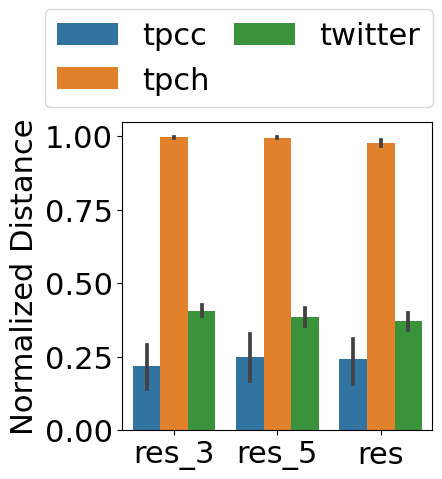

In [17]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='l21')
    simi_mtxs.append(simi_calc.simi_mtx)
    result_stats = pred_stats(simi_calc, n=1, dependent=True, print_label=True)

plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 1, 'MTS L21 Norm', colwise=True, note='')

  run workload feature_group  distance
1   1     tpcc         res_3  0.055141
0   1     tpcc         res_3  0.066730
4   7     tpcc         res_3  0.266729
3   7     tpcc         res_3  0.280402
2   7     tpcc         res_3  0.281608
6   8     tpcc         res_3  0.407077
5   8     tpcc         res_3  0.415534
7   8     tpcc         res_3  0.419754
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.MTS L11 Norm


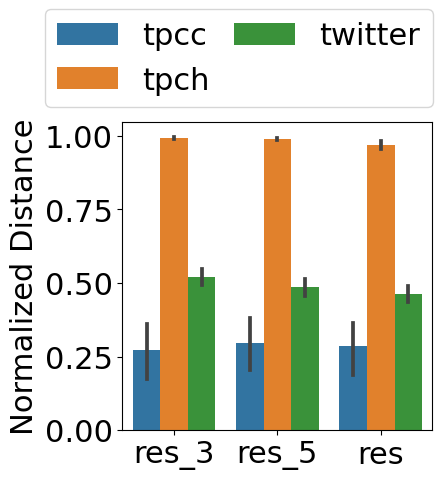

In [18]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='l11')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 1, 'MTS L11 Norm', colwise=True, note='')

  run workload feature_group  distance
1   1     tpcc         res_3  0.052460
0   1     tpcc         res_3  0.072340
4   7     tpcc         res_3  0.275662
3   7     tpcc         res_3  0.285588
2   7     tpcc         res_3  0.291334
6   8     tpcc         res_3  0.430408
5   8     tpcc         res_3  0.439636
7   8     tpcc         res_3  0.444925
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.MTS Fro Norm


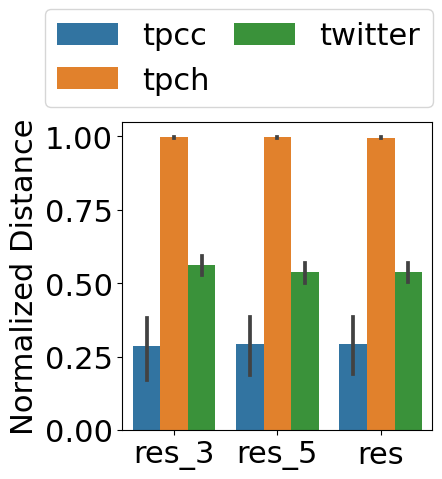

In [19]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='fro')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 1, 'MTS Fro Norm', colwise=True, note='')

  run workload feature_group  distance
0   1     tpcc         res_3  0.040810
1   1     tpcc         res_3  0.054233
4   7     tpcc         res_3  0.392856
2   7     tpcc         res_3  0.403862
3   7     tpcc         res_3  0.429200
5   8     tpcc         res_3  0.534018
7   8     tpcc         res_3  0.536431
6   8     tpcc         res_3  0.541714
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.MTS Canb Norm


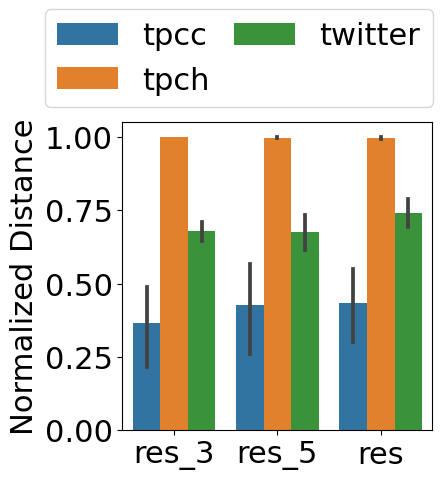

In [20]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='canb')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 1, 'MTS Canb Norm', colwise=True, note='')

  run workload feature_group  distance
1   1     tpcc         res_3  0.073599
5   8     tpcc         res_3  0.157647
4   7     tpcc         res_3  0.176538
3   7     tpcc         res_3  0.188875
0   1     tpcc         res_3  0.189795
2   7     tpcc         res_3  0.192827
6   8     tpcc         res_3  0.193702
7   8     tpcc         res_3  0.226835
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.MTS Corr Norm


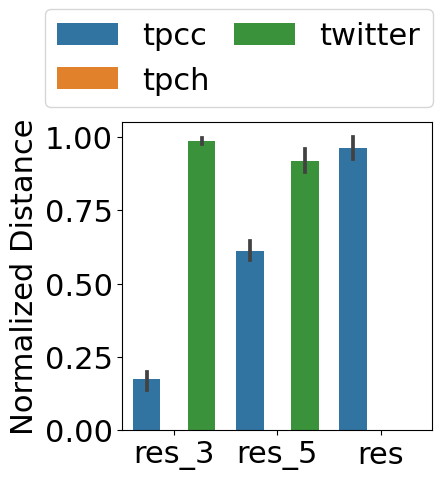

In [21]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='corr')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 1, 'MTS Corr Norm', colwise=True, note='')

  run workload feature_group  distance
0   1     tpcc         res_3       NaN
1   1     tpcc         res_3       NaN
2   7     tpcc         res_3       NaN
3   7     tpcc         res_3       NaN
4   7     tpcc         res_3       NaN
5   8     tpcc         res_3       NaN
6   8     tpcc         res_3       NaN
7   8     tpcc         res_3       NaN
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.MTS Chi2 Norm


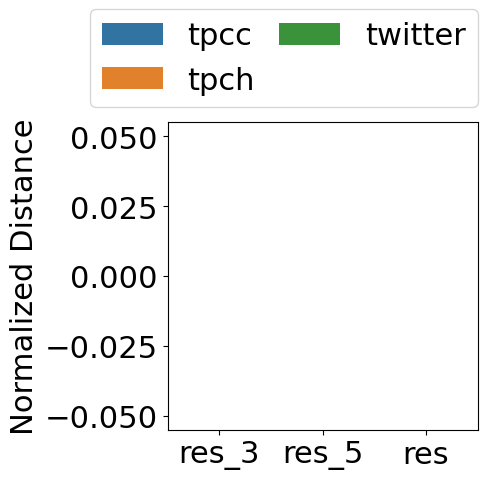

In [22]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='chi2')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 1, 'MTS Chi2 Norm', colwise=True, note='')

In [23]:
'''        
if colwise:
    simi_mtx = simi_calc.simi_col_mtx
else:
    simi_mtx = simi_calc.simi_mtx
'''
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='l21')
    simi_mtxs.append(simi_calc.simi_mtx)

   run workload feature_group  distance
78   1     tpcc         res_3  0.039199
79   1     tpcc         res_3  0.050728
82   7     tpcc         res_3  0.311589
81   7     tpcc         res_3  0.318345
80   7     tpcc         res_3  0.324937
84   8     tpcc         res_3  0.396304
83   8     tpcc         res_3  0.399136
85   8     tpcc         res_3  0.399201
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Cumulative Histogram L21 Norm


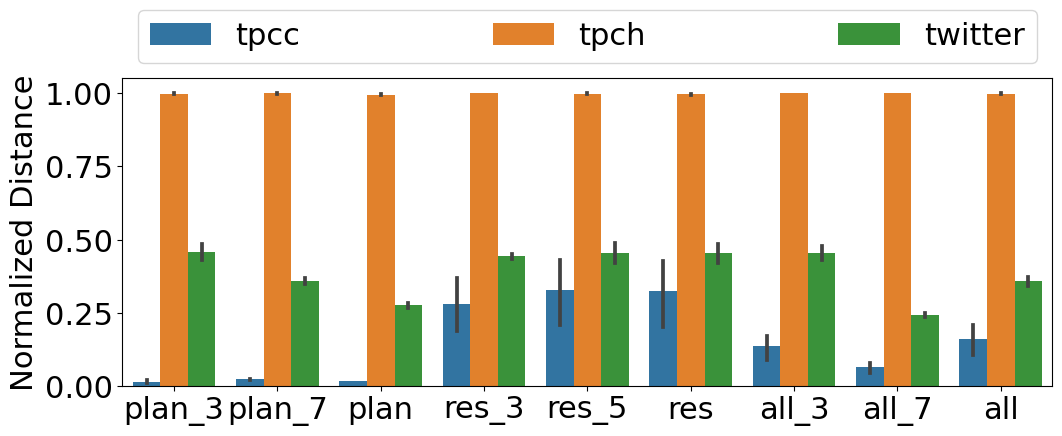

In [24]:
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Cumulative Histogram L21 Norm', colwise=True, note='')

   run workload feature_group  distance
78   1     tpcc         res_3  0.050739
79   1     tpcc         res_3  0.065662
82   7     tpcc         res_3  0.403317
81   7     tpcc         res_3  0.412062
80   7     tpcc         res_3  0.420594
84   8     tpcc         res_3  0.512971
83   8     tpcc         res_3  0.516637
85   8     tpcc         res_3  0.516720
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Cumulative Histogram L11 Norm


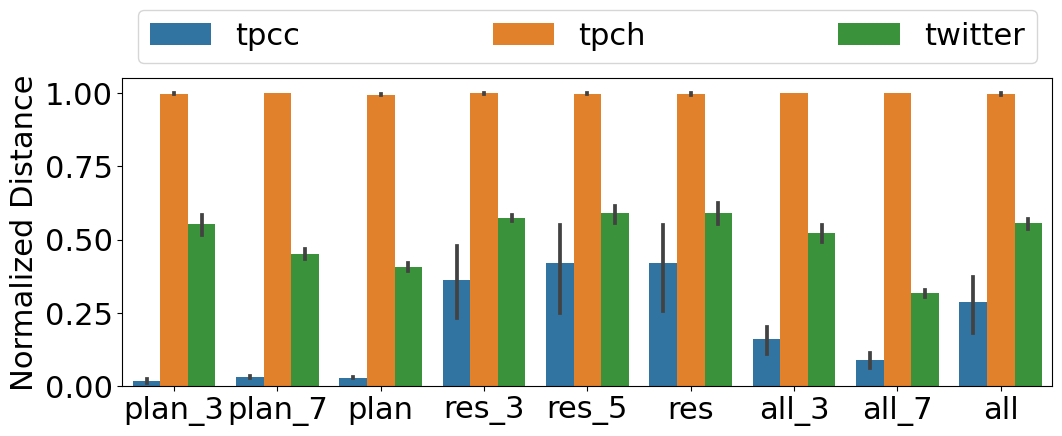

In [25]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='l11')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Cumulative Histogram L11 Norm', colwise=True, note='')

   run workload feature_group  distance
78   1     tpcc         res_3  0.052033
79   1     tpcc         res_3  0.062175
82   7     tpcc         res_3  0.398271
81   7     tpcc         res_3  0.408648
80   7     tpcc         res_3  0.418834
84   8     tpcc         res_3  0.532141
83   8     tpcc         res_3  0.536724
85   8     tpcc         res_3  0.536828
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Cumulative Histogram Fro Norm


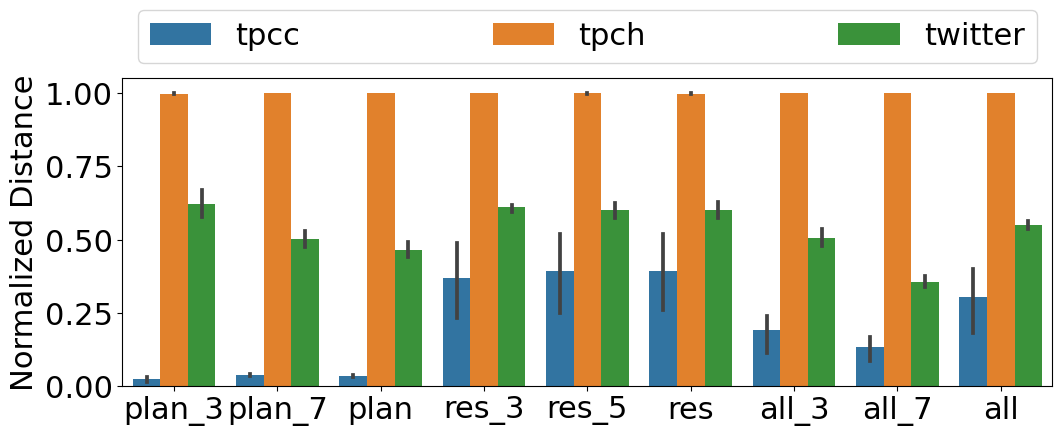

In [26]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='fro')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Cumulative Histogram Fro Norm', colwise=True, note='')

   run workload feature_group  distance
79   1     tpcc         res_3  0.051475
78   1     tpcc         res_3  0.071410
82   7     tpcc         res_3  0.202431
81   7     tpcc         res_3  0.207389
80   7     tpcc         res_3  0.212894
84   8     tpcc         res_3  0.284996
83   8     tpcc         res_3  0.285072
85   8     tpcc         res_3  0.297415
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Cumulative Histogram Canb Norm


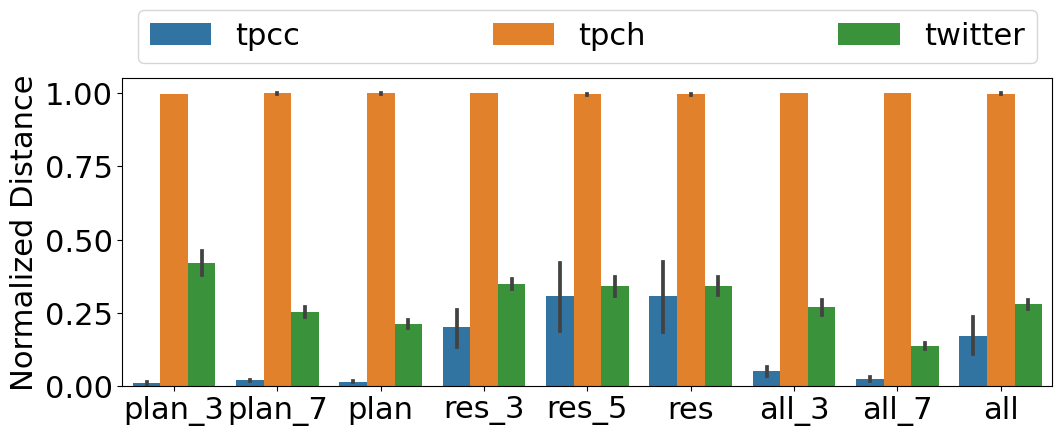

In [27]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='canb')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Cumulative Histogram Canb Norm', colwise=True, note='')

   run workload feature_group  distance
78   1     tpcc         res_3  0.004436
79   1     tpcc         res_3  0.006689
82   7     tpcc         res_3  0.151812
81   7     tpcc         res_3  0.158393
80   7     tpcc         res_3  0.164955
84   8     tpcc         res_3  0.264606
83   8     tpcc         res_3  0.267139
85   8     tpcc         res_3  0.268379
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Cumulative Histogram Chi2 Norm


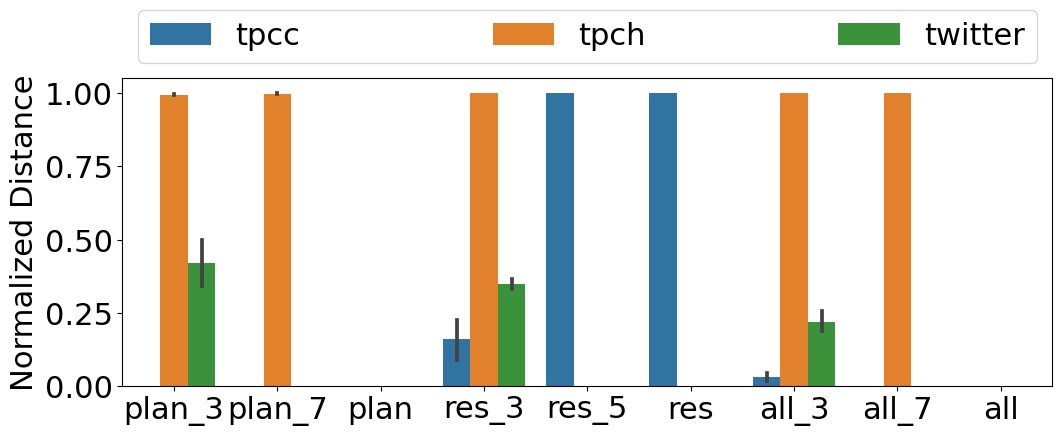

In [28]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='chi2')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Cumulative Histogram Chi2 Norm', colwise=True, note='')

   run workload feature_group  distance
78   1     tpcc         res_3       NaN
79   1     tpcc         res_3       NaN
80   7     tpcc         res_3       NaN
81   7     tpcc         res_3       NaN
82   7     tpcc         res_3       NaN
83   8     tpcc         res_3       NaN
84   8     tpcc         res_3       NaN
85   8     tpcc         res_3       NaN
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Cumulative Histogram Corr Norm


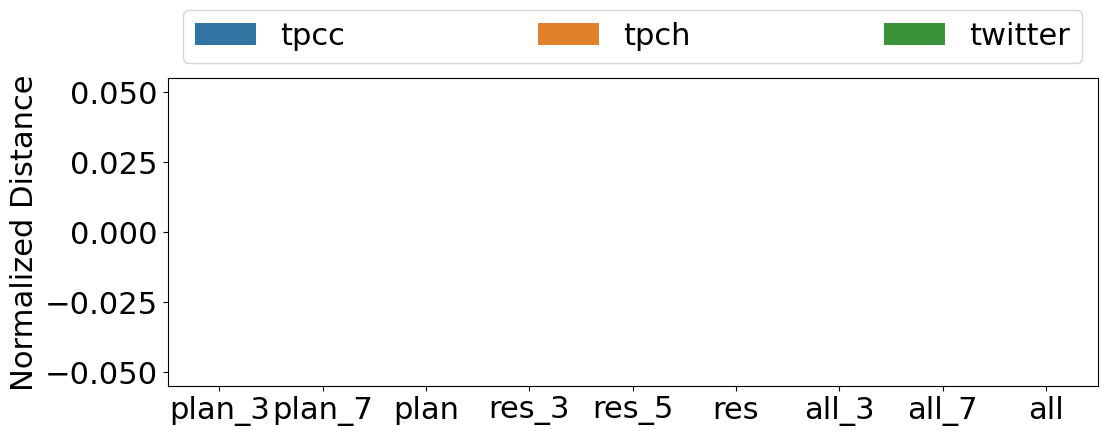

In [29]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='corr')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Cumulative Histogram Corr Norm', colwise=True, note='')

#### Phase Stats FP Distance Measure

   run workload feature_group  distance
79   1     tpcc         res_3  0.118779
78   1     tpcc         res_3  0.120061
82   7     tpcc         res_3  0.483471
80   7     tpcc         res_3  0.486012
81   7     tpcc         res_3  0.490091
84   8     tpcc         res_3  0.582776
83   8     tpcc         res_3  0.587496
85   8     tpcc         res_3  0.592388
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Phase Fingerprint L21 Norm


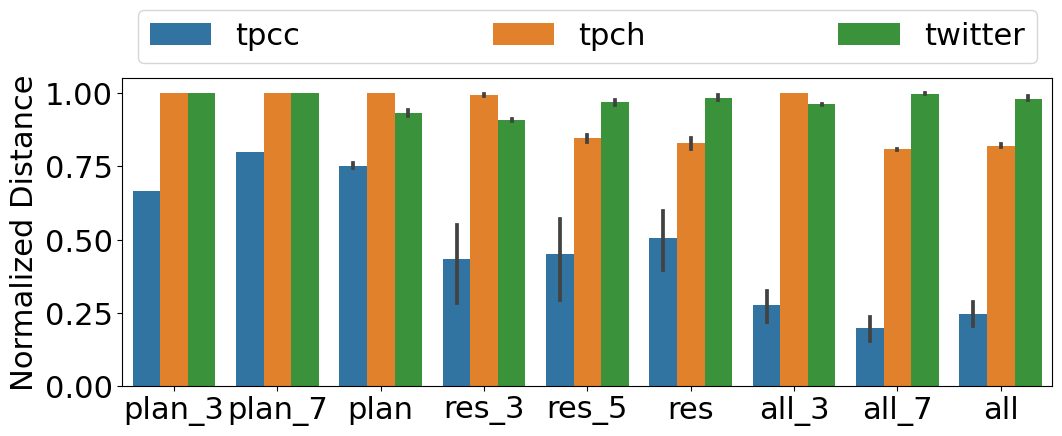

In [30]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='l21')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Phase Fingerprint L21 Norm', colwise=True, note='')

   run workload feature_group  distance
79   1     tpcc         res_3  0.134659
78   1     tpcc         res_3  0.153145
82   7     tpcc         res_3  0.473153
80   7     tpcc         res_3  0.476010
81   7     tpcc         res_3  0.481288
84   8     tpcc         res_3  0.561589
83   8     tpcc         res_3  0.565559
85   8     tpcc         res_3  0.570602
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Phase Fingerprint L11 Norm


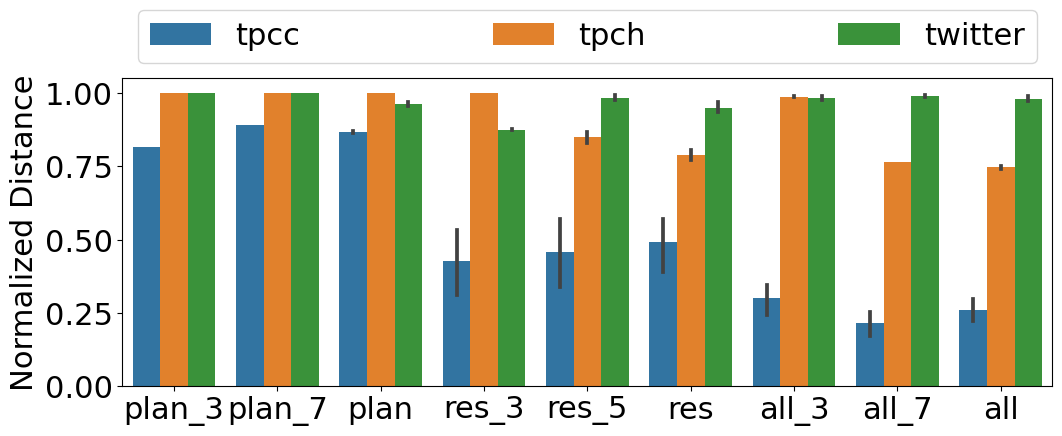

In [31]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='l11')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Phase Fingerprint L11 Norm', colwise=True, note='')

   run workload feature_group  distance
79   1     tpcc         res_3  0.144351
78   1     tpcc         res_3  0.154241
82   7     tpcc         res_3  0.490661
80   7     tpcc         res_3  0.493419
81   7     tpcc         res_3  0.498180
84   8     tpcc         res_3  0.588164
83   8     tpcc         res_3  0.591741
85   8     tpcc         res_3  0.597467
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Phase Fingerprint Fro Norm


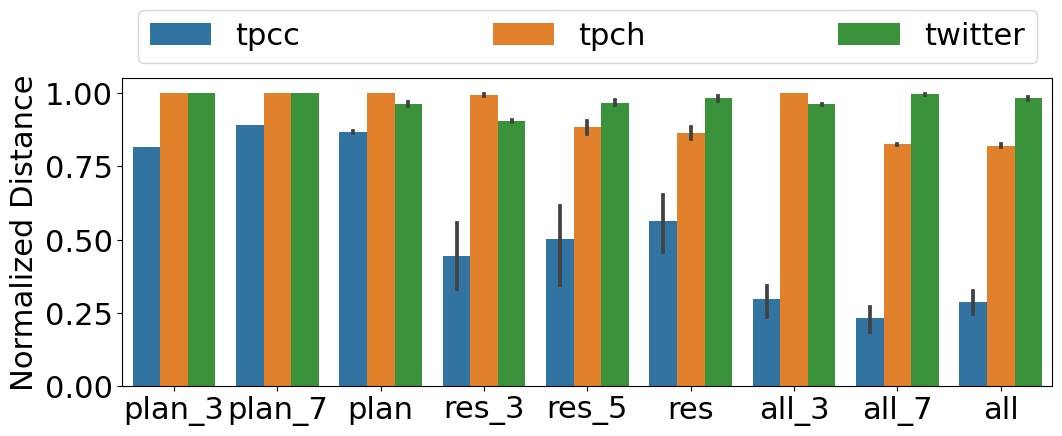

In [32]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='fro')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Phase Fingerprint Fro Norm', colwise=True, note='')

   run workload feature_group  distance
78   1     tpcc         res_3  0.228838
79   1     tpcc         res_3  0.243869
82   7     tpcc         res_3  0.436437
80   7     tpcc         res_3  0.437841
81   7     tpcc         res_3  0.443207
84   8     tpcc         res_3  0.506144
83   8     tpcc         res_3  0.509128
85   8     tpcc         res_3  0.513310
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Phase Fingerprint Canb Norm


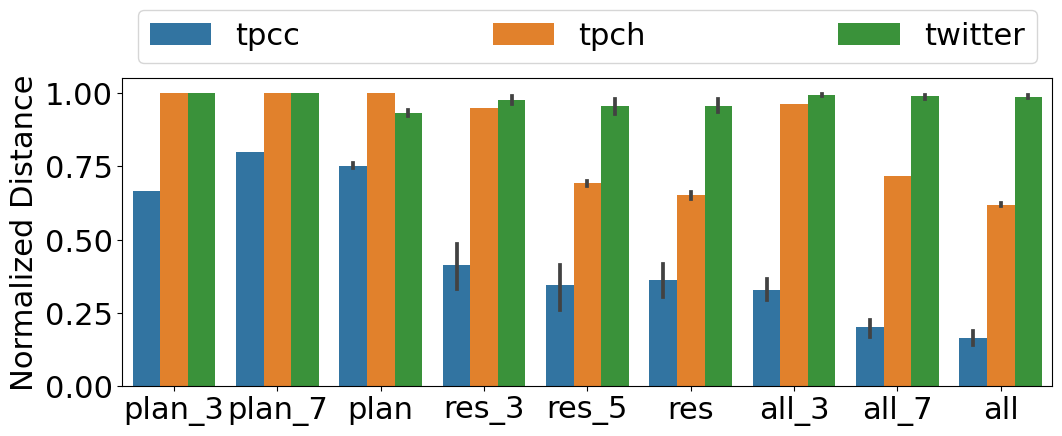

In [33]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='canb')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Phase Fingerprint Canb Norm', colwise=True, note='')

    run workload feature_group  distance
95    3  twitter         res_3  0.977136
97    3  twitter         res_3  0.980750
96    3  twitter         res_3  0.984919
100   4  twitter         res_3  0.985545
99    4  twitter         res_3  0.985821
98    4  twitter         res_3  0.986773
101   9  twitter         res_3  0.997897
103   9  twitter         res_3  0.998373
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Phase Fingerprint Chi2 Norm


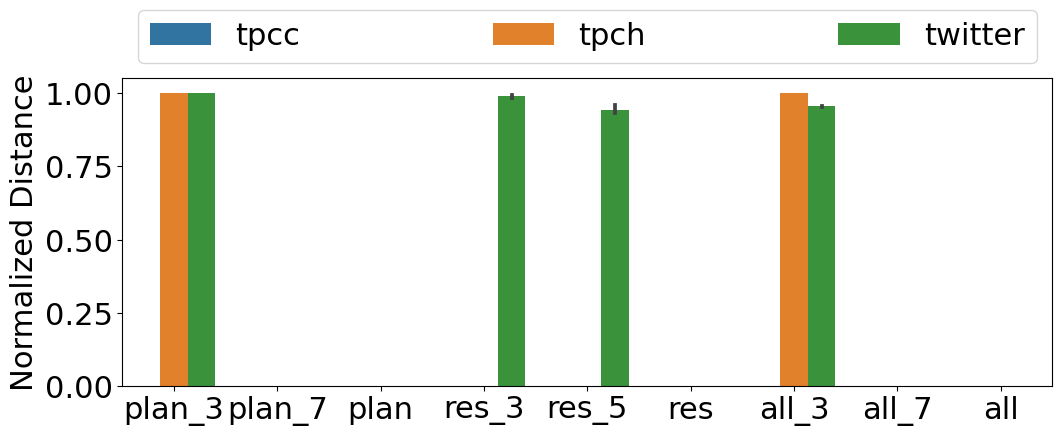

In [34]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='chi2')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Phase Fingerprint Chi2 Norm', colwise=True, note='')

   run workload feature_group      distance
78   1     tpcc         res_3  1.665335e-16
79   1     tpcc         res_3  1.665335e-16
81   7     tpcc         res_3  3.330669e-16
80   7     tpcc         res_3  1.000000e+00
84   8     tpcc         res_3  1.000000e+00
82   7     tpcc         res_3  1.000000e+00
83   8     tpcc         res_3  1.000000e+00
85   8     tpcc         res_3  1.000000e+00
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Phase Fingerprint Corr Norm


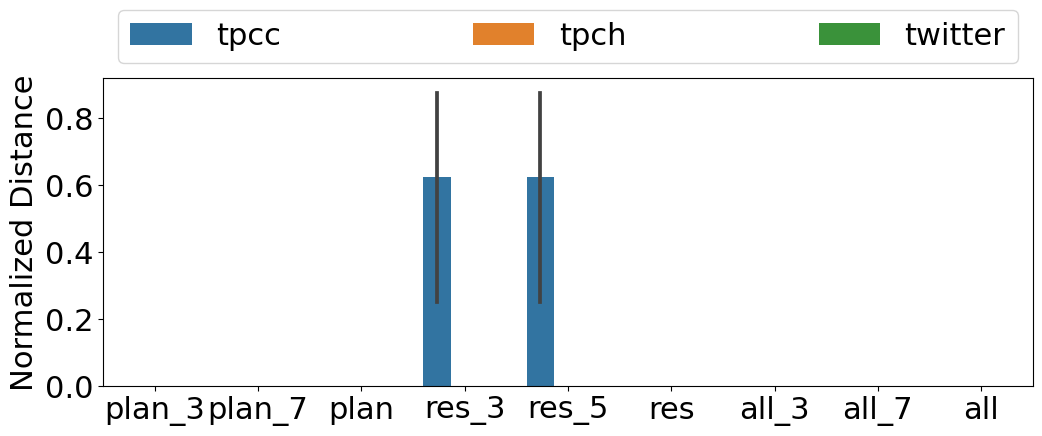

In [35]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='corr')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 1, 'Phase Fingerprint Corr Norm', colwise=True, note='')

#### Dependent DTW

  run workload feature_group  distance
1   1     tpcc         res_3  0.026597
0   1     tpcc         res_3  0.040784
4   7     tpcc         res_3  0.206684
3   7     tpcc         res_3  0.206748
2   7     tpcc         res_3  0.220519
6   8     tpcc         res_3  0.325824
5   8     tpcc         res_3  0.333337
7   8     tpcc         res_3  0.337347
(26, 4)
Base Workload: tpcc, Method: cpu16 Dependent.Dependent DTW


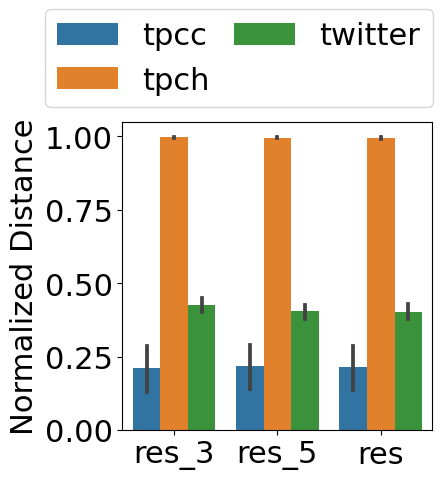

In [36]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_dtw_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 1, 'Dependent DTW', colwise=False, note='')

#### Independent DTW

  run workload feature_group  distance
1   1     tpcc         res_3  0.016055
0   1     tpcc         res_3  0.020772
4   7     tpcc         res_3  0.171810
3   7     tpcc         res_3  0.178146
2   7     tpcc         res_3  0.183566
6   8     tpcc         res_3  0.266996
5   8     tpcc         res_3  0.270756
7   8     tpcc         res_3  0.273502
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Independent DTW


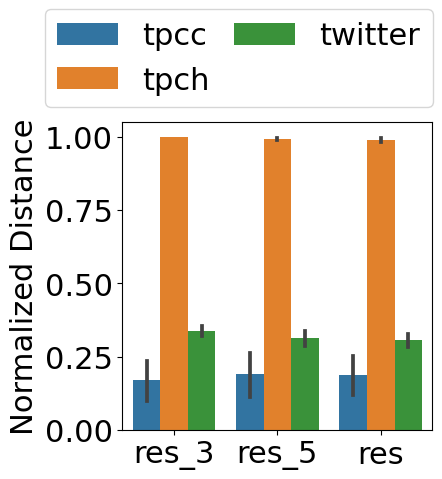

In [37]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_ind_dtw_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_col_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 1, 'Independent DTW', colwise=True, note='')

#### Dependent LCSS

  run workload feature_group  distance
0   1     tpcc         res_3  0.000000
1   1     tpcc         res_3  0.000000
3   7     tpcc         res_3  0.213115
4   7     tpcc         res_3  0.213115
2   7     tpcc         res_3  0.295082
6   8     tpcc         res_3  0.918033
5   8     tpcc         res_3  0.967213
7   8     tpcc         res_3  0.967213
(26, 4)
Base Workload: tpcc, Method: cpu16 Dependent.Dependent LCSS


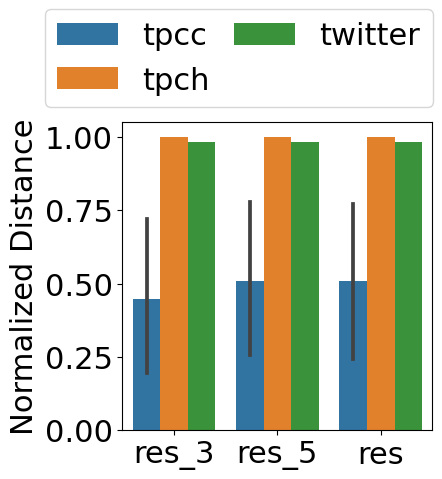

In [38]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_lcss_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 1, 'Dependent LCSS', colwise=False, note='')

#### Independent LCSS

  run workload feature_group  distance
1   1     tpcc         res_3  0.016484
0   1     tpcc         res_3  0.043956
2   7     tpcc         res_3  0.516484
4   7     tpcc         res_3  0.516484
3   7     tpcc         res_3  0.527473
5   8     tpcc         res_3  0.543956
7   8     tpcc         res_3  0.543956
6   8     tpcc         res_3  0.549451
(26, 4)
Base Workload: tpcc, Method: cpu16 Independent.Independent LCSS


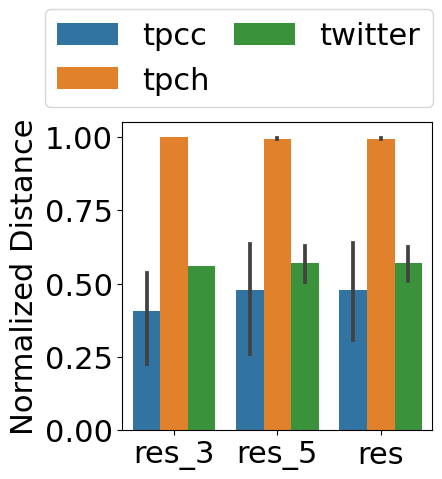

In [39]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_ind_lcss_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_col_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 1, 'Independent LCSS', colwise=True, note='')